<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/InfoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset, Dataset
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import glob

from itertools import chain

In [94]:
# CONTROL VARIABLES

# GAN style
# 0: InfoGAN
# 1: AC-GAN (Auxiliary Conditional GAN)
GAN_STYLE = 1


# lesser importance variables
BATCH_SIZE = 256
LRELU_ALPHA = 0.01 #negative slope of leaky relu activation
LR_G = 0.001 #generator learning rate
LR_D = 0.001 #discriminator learning rate
EPSILON = 0 #noise factor in images to discriminator
GEN_PER_DISCR = 2 #times the generator is trained each time the discriminator is trained

We are going to create a GAN to generate new fonts

In [95]:
# Access to the BOB ROSS images folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [96]:
#directory = "gdrive/MyDrive/UNIVERSIDAD/Master Propio IA UV/3 Aprendizaje profundo (II)/Datasets/Bob Ross/train"
directory = "gdrive/MyDrive/UNIVERSIDAD/Master Propio IA UV/3 Aprendizaje profundo (II)/Trabajo final/fonts"

In [97]:
# get data file names (this code takes a while to retrieve all data and prepare all dataframes)
filenames = glob.glob(directory + "/*.csv")
dfs = [pd.read_csv(filename) for filename in filenames]

In [98]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [99]:
# Characters have an index associated to them (m_label). The index is related to the character in the following dictionary
index_to_char = {65:'A', 66:'B', 67:'C', 68:'D', 69:'E', 70:'F', 71:'G', 72:'H', 73:'I', 74:'J',
                 75:'K', 76:'L', 77:'M', 78:'N', 79:'O', 80:'P', 81:'Q', 82:'R', 83:'S', 84:'T',
                 85:'U', 86:'V', 87:'W', 88:'X', 89:'Y', 90:'Z', 97:'a', 98:'b', 99:'c', 100:'d',
                 101:'e', 102:'f', 103:'g', 104:'h', 105:'i', 106:'j', 107:'k', 108:'l', 109:'m',
                 110:'n', 111:'o', 112:'p', 113:'q', 114:'r', 115:'s', 116:'t', 117:'u', 118:'v',
                 119:'w', 120:'x', 121:'y', 122:'z', 48:'0', 49:'1', 50:'2', 51:'3', 52:'4', 53:'5',
                 54:'6', 55:'7', 56:'8', 57:'9'}

In [100]:
number_min = 48
number_max = 57
upper_min = 65
upper_max = 90
lower_min = 97
lower_max = 122

In [101]:
# We create the datasets. We are going to divide them in NUMBERS, UPPERCASE LETTERS and LOWERCASE LETTERS
X_numbers = np.array([], ndmin=3)
X_upper = np.array([], ndmin=3)
X_lower = np.array([], ndmin=3)
Y_numbers = np.array([], ndmin=2)
Y_upper = np.array([], ndmin=2)
Y_lower = np.array([], ndmin=2)

i = 0
for df in dfs:
  #df = df[np.logical_and(df.loc[:,'strength'] < 0.5, df.loc[:,'italic'] == 0]
  df_straight = df[np.logical_and(df.loc[:,'strength'] < 0.5, df.loc[:,'italic'] == 0)] #remove the columns that are in bold or cursive
  #BY SLIGHTLY MODIFYING THIS LINE OF CODE AND ADDING THE CORRESPONDING LABELS TO Y, CURSIVE AND BOLD CAN BE ADDED TO THE MODEL

  # We get the elements of the dataframe that reference the images of characters (upper and lower letters, and numbers)
  X_numbers_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= number_min, df_straight.loc[:, 'm_label'] <= number_max)].iloc[:, 12:]
  X_upper_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= upper_min, df_straight.loc[:, 'm_label'] <= upper_max)].iloc[:, 12:]
  X_lower_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= lower_min, df_straight.loc[:, 'm_label'] <= lower_max)].iloc[:, 12:]

  Y_numbers_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= number_min, df_straight.loc[:, 'm_label'] <= number_max)].loc[:, ['m_label', 'font']]
  Y_upper_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= upper_min, df_straight.loc[:, 'm_label'] <= upper_max)].loc[:, ['m_label', 'font']]
  Y_lower_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= lower_min, df_straight.loc[:, 'm_label'] <= lower_max)].loc[:, ['m_label', 'font']]

  # We transform each element from a 400x1 array into a 20x20 array
  #X_numbers_new = np.reshape(X_numbers_new.values, (20,20,-1))
  #X_upper_new = np.reshape(X_upper_new.values, (20,20,-1))
  #X_lower_new = np.reshape(X_lower_new.values, (20,20,-1))

  # We rearrange the indexes so that the first index refers to image index
  #X_numbers_new = np.transpose(X_numbers_new, axes=[2, 0, 1])
  #X_upper_new = np.transpose(X_upper_new, axes=[2, 0, 1])
  #X_lower_new = np.transpose(X_lower_new, axes=[2, 0, 1])

  X_numbers_new = np.array(np.reshape(X_numbers_new.values, (-1,20,20)))
  X_upper_new = np.array(np.reshape(X_upper_new.values, (-1,20,20)))
  X_lower_new = np.array(np.reshape(X_lower_new.values, (-1,20,20)))

  X_numbers_new = X_numbers_new.astype('float64')
  X_upper_new = X_upper_new.astype('float64')
  X_lower_new = X_lower_new.astype('float64')

  Y_numbers_new.iloc[:, 0] = Y_numbers_new.iloc[:, 0].astype('int')
  Y_upper_new.iloc[:, 0] = Y_upper_new.iloc[:, 0].astype('int')
  Y_lower_new.iloc[:, 0] = Y_lower_new.iloc[:, 0].astype('int')

  # We append the _new vectors to the standard vectors
  if i == 0: # IS THERE A WAY TO PROGRAM THIS BETTER?
    X_numbers = X_numbers_new
    X_upper = X_upper_new
    X_lower = X_lower_new

    Y_numbers = Y_numbers_new
    Y_upper = Y_upper_new
    Y_lower = Y_lower_new

  else:
    X_numbers = np.concatenate((X_numbers, X_numbers_new), axis=0)
    X_upper = np.concatenate((X_upper, X_upper_new), axis=0)
    X_lower = np.concatenate((X_lower, X_lower_new), axis=0)

    Y_numbers = pd.concat([Y_numbers, Y_numbers_new], axis=0)
    Y_upper = pd.concat([Y_upper, Y_upper_new], axis=0)
    Y_lower = pd.concat([Y_lower, Y_lower_new], axis=0)

    #Y_numbers = np.concatenate((Y_numbers, np.array(Y_numbers_new)), axis=0)
    #Y_upper = np.concatenate((Y_upper, np.array(Y_upper_new)), axis=0)
    #Y_lower = np.concatenate((Y_lower, np.array(Y_lower_new)), axis=0)

    
  #X_numbers.append(X_numbers_new)
  #X_upper.append(X_upper_new)
  #X_lower.append(X_lower)

  #Y_numbers.append(Y_numbers_new)
  #Y_upper.append(Y_upper_new)
  #Y_lower.append(Y_lower_new)
  
  i += 1
  if i % 10 == 0 or i==len(dfs):
    print(str(i)+'/'+str(len(dfs)))

  #for row in df[np.logical_and(df.loc[:,'strength'] < 0.5, df.loc[:,'italic'] == 0].iterrows():
   # if row.strength < 0.5 and row.italic == 0:

#Y_numbers.reset_index(inplace=True)
#Y_lower.reset_index(inplace=True)
#Y_upper.reset_index(inplace=True)

10/153
20/153
30/153
40/153
50/153
60/153
70/153
80/153
90/153
100/153
110/153
120/153
130/153
140/153
150/153
153/153


In [102]:
#THIS CODE IS NOW RENDERED UNNECESSARY

#print('finish0')
#X_numbers = np.concatenate(X_numbers, axis=0)
##print('finish1')
#X_upper = np.concatenate(X_upper, axis=0)
#print('finish2')
#X_lower = np.concatenate(X_lower, axis=0)
#print('finish3')

#Y_numbers = np.concatenate(Y_numbers, axis=0)
#print('finish4')
#Y_upper = np.concatenate(Y_upper, axis=0)
#print('finish5')
#Y_lower = np.concatenate(Y_lower, axis=0)
#print('finish6')

In [103]:
# We create a custom transform that can escale the images to [-1, 1] the range that's typically used
# in GANs. It's the image of the function tanh(), used sometimes as the last activation function
# in generators

class ToTanh(object):
    """Convert single-channel images from range [0, 256] to range [-1, 1]."""

    def __call__(self, pic):
        return torch.tensor(pic * 2 - 1, dtype=torch.float)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [104]:
# Generation of the transform for the DataLoader
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
  #ToTanh()
])

In [105]:
#Append the Y columns at the end of the X columns

#X_numbers = np.concatenate([X_numbers, Y_numbers], axis=1)
#X_upper = np.concatenate([X_upper, Y_upper], axis=1)
#X_lower = np.concatenate([])

In [106]:
#We modify the dataset class to fit our needs: deliver an image and a label per example
class FontsDataset(Dataset):

    def __init__(self, X_images, Y_labels, transform=None):
        """
        Args:
            X_images (np.array): np.array containing all the font images
            Y_labels (np.array): np.array containing all the font labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X_images = X_images
        #self.X_images.type(torch.FloatTensor)
        #for now, we only want to keep the column that indicates the character
        self.Y_labels = Y_labels.iloc[:,0]
        #we also apply one-hot encoding to the labels.
        #USE EMBEDDING FOR BIGGER COLLECTIONS OF CHARACTERS
        #self.Y_labels = np.array(pd.get_dummies(Y_labels.astype('str')))
        self.transform = transform

    def __len__(self):
        return len(self.Y_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img_name = os.path.join(self.root_dir,
        #                        self.landmarks_frame.iloc[idx, 0])
        #image = io.imread(img_name)
        #landmarks = self.landmarks_frame.iloc[idx, 1:]
        #landmarks = np.array([landmarks])
        #landmarks = landmarks.astype('float').reshape(-1, 2)
        #sample = {'image': image, 'landmarks': landmarks}

        image = self.X_images[idx]
        label = self.Y_labels[idx]

        if self.transform:
            image = self.transform(image)
            image.type(torch.FloatTensor)

        return image, label

In [107]:
#plt.imshow(numbers_dataset.X_images[0,:,:])

In [108]:
#Y_numbers.reset_index(drop=True).head(50)

In [109]:
#numbers_dataset.Y_labels[0]

In [110]:
#max(numbers_dataset.Y_labels)

In [111]:
#type(numbers_dataset.Y_labels[0])

In [112]:
# We want the label to go from 0 to label_max. In order to do that,
# the following operation needs to be performed:

Y_numbers.iloc[:, 0] = Y_numbers.iloc[:, 0] - number_min
Y_upper.iloc[:, 0] = Y_upper.iloc[:, 0] - upper_min
Y_lower.iloc[:, 0] = Y_lower.iloc[:, 0] - lower_min

Y_numbers.reset_index(drop=True, inplace=True)
Y_upper.reset_index(drop=True, inplace=True)
Y_lower.reset_index(drop=True, inplace=True)

In [113]:
numbers_dataset = FontsDataset(X_numbers, Y_numbers, transform)
upper_dataset = FontsDataset(X_upper, Y_upper, transform)
lower_dataset = FontsDataset(X_lower, Y_lower, transform)

numbers_loader = DataLoader(numbers_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
upper_loader = DataLoader(upper_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
lower_loader = DataLoader(lower_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [114]:
numbers_dataset.Y_labels.unique()

array([3, 8, 1, 2, 5, 9, 7, 0, 6, 4])

In [115]:
#FUNCIÓN PARA PROBAR COSAS
# SE IRÁ DEL CÓDIGO EVENTUALMENTE

#index = 21

#plt.figure()
#for i in np.arange(index, index+10):
#  plt.imshow(X_numbers[i])
#  plt.show()

In [116]:
#FUNCIÓN PARA PROBAR COSAS
# SE IRÁ DEL CÓDIGO EVENTUALMENTE

#Esta función en concreto busca todos los caracteres de un tipo en concreto
# y los dibuja

#char_one = dfs[0].loc[:, 'm_label'] == 57
#chars = dfs[0][char_one]
#for i in range(chars.shape[0]):
#  chars2 = np.array(chars.iloc[i, 12:])
#  chars3 = np.reshape(chars2, newshape=(20,20))
#  plt.figure()
#  plt.imshow(chars3.astype(float))
#  plt.show()

### Building the GAN

In [117]:
#this is the tensor used as 'error', or 'output not expected', as
# using None is not possible because it raises some errors
error_tensor = -1 * torch.ones(1)
error_tensor = error_tensor.to(device)

In [118]:
##Right now, the generator only generates one image per execution,
## maybe it should be readapted to generate a BATCH of images
## EDIT: readapted!!

class Generator(nn.Module):
  def __init__(self, noise_dim=50, categorical_dim=10, categorical_noise_dim=30, image_size=20):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.categorical_dim = categorical_dim
    self.categorical_noise_dim = categorical_noise_dim

    self.image_size = image_size #size of one of the sides of the image (we are working with square images)
    self.hidden_channels = 128 #channels of the first convolutional layer
    self.output_channels = 1 #the images we work with are black & white

    self.hidden_layer = self.hidden_channels * (self.image_size // 4) ** 2

    self.linear = nn.Linear(self.noise_dim + self.categorical_dim + self.categorical_noise_dim, self.hidden_layer)
    self.bn = nn.BatchNorm1d(self.hidden_layer)
    self.bn2 = nn.BatchNorm2d(self.hidden_channels//2)
    #self.upscale = F.upsample_bilinear(2)
    #self.upscale = nn.PixelShuffle(upscale_factor=2) # Better than F.upsample_bilinear: training GANs means avoiding sparse gradients
    self.conv1 = nn.Conv2d(self.hidden_channels, self.hidden_channels//2, (3,3), stride=1, padding=1)
    self.conv2 = nn.Conv2d(self.hidden_channels//2, self.output_channels, (3,3), stride=1, padding=1)

    #self.conv3 = nn.Conv2d(self.hidden_channels//4, self.hidden_channels//8, (3,3), stride=1, padding=1)


  def forward(self, z, cat, z_cat):
    if not z_cat == error_tensor:
      x = self.bn(F.leaky_relu(self.linear(torch.cat((z, cat, z_cat), axis=1)), negative_slope=LRELU_ALPHA))
    else:
      #x = self.bn(F.leaky_relu(self.linear(torch.cat((z, cat), axis=1)), negative_slope=LRELU_ALPHA))
      x = self.bn(F.relu(self.linear(torch.cat((z, cat), axis=1))))
    x = x.view(-1, self.hidden_channels, self.image_size // 4, self.image_size // 4)
    x = F.interpolate(x, scale_factor=2)
    # ITER 1:  x = self.bn2(F.leaky_relu(self.conv1(x), negative_slope=LRELU_ALPHA))
    # ITER 2:  x = self.bn2(F.relu(self.conv1(x)))
    # ITER 3:
    x = F.relu(self.conv1(x))
    x = F.interpolate(x, scale_factor=2)
    x = torch.tanh(self.conv2(x))

    return x

In [119]:
class Discriminator(nn.Module):
  def __init__(self, noise_dim=50, categorical_dim=10, categorical_noise_dim=30, image_size=20):
    super(Discriminator, self).__init__()

    self.noise_dim = noise_dim
    self.categorical_dim = categorical_dim
    self.categorical_noise_dim = categorical_noise_dim

    self.image_size = image_size #size of one of the sides of the image (we are working with square images)
    self.hidden_channels = 128 #channels of the last convolutional layer
    self.input_channels = 1 #the images we work with are black & white

    self.hidden_layer = self.hidden_channels * (self.image_size // 4) ** 2

    self.conv1 = nn.Conv2d(self.input_channels, self.hidden_channels//2, (3,3), stride=1, padding=1)
    self.conv2 = nn.Conv2d(self.hidden_channels//2, self.hidden_channels, (3,3), stride=1, padding=1)

    self.bn = nn.BatchNorm2d(self.hidden_channels//2)
    self.bn2 = nn.BatchNorm2d(self.hidden_channels)
    self.avgpool = nn.AvgPool2d(kernel_size=2)
    self.flatten = nn.Flatten()

    self.true_dense = nn.Linear(self.hidden_layer, 1)
    self.cat_dense = nn.Linear(self.hidden_layer, self.categorical_dim)
    if categorical_noise_dim > 0:
      self.noise_dense = nn.Linear(self.hidden_layer, self.categorical_noise_dim)


  def forward(self, x):
    x = self.bn(self.avgpool(F.leaky_relu(self.conv1(x), negative_slope=LRELU_ALPHA)))
    x = self.bn2(self.avgpool(F.leaky_relu(self.conv2(x), negative_slope=LRELU_ALPHA)))
    x = self.flatten(x)
    #true = F.sigmoid(self.true_dense(x))
    true = torch.sigmoid(self.true_dense(x))
    cat = F.softmax(self.cat_dense(x))
    if self.categorical_noise_dim > 0:
      cat_noise = self.noise_dense(x)
    else:
      cat_noise = error_tensor

    return true, cat, cat_noise


In [120]:
#Generation of the different datasets that we're going to send to the generator
def generate_generator_data(batch_size, noise_dim=50, cat_dim=10, noise_cat_dim=30, same_class=True):

  noise = torch.normal(mean=0, std=1, size=(batch_size, noise_dim))

  #The categorical variable has to be one-hot encoded. This process does exactly that
  cat = torch.zeros(size=(batch_size, cat_dim))
  
  #Generate all the data from the same class?
  #TRUE
  if same_class:
    cat_result = torch.randint(low=0, high=cat_dim, size=(1,))
    for i in range(batch_size):
      cat[i, cat_result[0]] = 1
  #FALSE
  else:
    cat_vector = torch.randint(low=0, high=cat_dim, size=(batch_size,))
    for i in range(batch_size):
      cat[i, cat_vector[i]] = 1

  if noise_cat_dim > 0:
    noise_cat = torch.normal(mean=0, std=1, size=(batch_size, noise_cat_dim))
  else:
    noise_cat = error_tensor

  return noise, cat, noise_cat

In [121]:
# Dummification in torch
def torch_dummies(variable, dim):
  cat = torch.zeros(size=(len(variable), dim))
  for i in range(len(variable)):
    cat[i, variable[i]] = 1
  return cat

In [126]:
# MODEL SETUP (Gen, Discr, Loss, Optimizer)

# After defining the generator and discriminator classes, we define the rest of elements
# that are necessary for the training: loss functions and optimizers

mse = nn.MSELoss()
cross_entropy = nn.CrossEntropyLoss()

mse, cross_entropy = mse.to(device), cross_entropy.to(device)

# Functions for the calculation of the loss function
def rand_ones_like(tensor):
  return torch.rand_like(tensor)*0.2 + 0.9

def rand_zeros_like(tensor):
  return torch.rand_like(tensor)*0.2

### Info-GAN ###
if GAN_STYLE == 0:

  lambda_cat = 1
  lambda_con = 0.1

  noise_dim = 50
  cat_dim = 10
  noise_cat_dim = 30

  generator = Generator(noise_dim=noise_dim, categorical_dim=cat_dim, categorical_noise_dim=noise_cat_dim)
  discriminator = Discriminator(noise_dim=noise_dim, categorical_dim=cat_dim, categorical_noise_dim=noise_cat_dim)

  generator = generator.to(device)
  discriminator = discriminator.to(device)


  # -- Definition for each of the losses
  # Generator loss: MSE Loss
  def gen_loss(pred):
    #print(max(pred))
    return mse(pred, rand_zeros_like(pred))

  # Discriminator loss: two batches of MSE loss: one for each batch (true images and )
  def discr_loss(real_pred, fake_pred):
    #print(max(real_pred), max(fake_pred))
    real_loss = mse(real_pred, rand_zeros_like(real_pred))
    fake_loss = mse(fake_pred, rand_ones_like(fake_pred))
    return (real_loss + fake_loss) / 2

  # Features loss: batch of noise and categories predicted by the discr.
  #  noise is continuous (MSE loss) and categories are not (cross entropy loss)
  def features_loss(cat_input, cat_pred, noise_input, noise_pred):
    return lambda_cat * cross_entropy(cat_input, torch.argmax(cat_pred, axis=1)) + lambda_con * mse(noise_input, noise_pred)

  # Optimizer definition
  gen_optim = torch.optim.Adam(generator.parameters(), lr=0.001)
  discr_optim = torch.optim.SGD(discriminator.parameters(), lr=0.001)
  features_optim = torch.optim.Adam(chain(generator.parameters(), discriminator.parameters()))

### AC-GAN ###
elif GAN_STYLE == 1:

  noise_dim = 80
  cat_dim = 10
  noise_cat_dim = 0 

  generator = Generator(noise_dim=noise_dim, categorical_dim=cat_dim, categorical_noise_dim=noise_cat_dim)
  discriminator = Discriminator(noise_dim=noise_dim, categorical_dim=cat_dim, categorical_noise_dim=noise_cat_dim)

  generator = generator.to(device)
  discriminator = discriminator.to(device)

  # -- Definition for each of the losses
  # Generator loss: MSE Loss
  def gen_loss(pred, cat_input, cat_pred):
    return 0.5 * (mse(pred, rand_ones_like(pred)) + cross_entropy(cat_input, torch.argmax(cat_pred, axis=1))/2.5)

  # Discriminator loss: two batches of MSE loss: one for each batch (true images and )
  def discr_loss(real_pred, fake_pred, real_cat_input, real_cat_labels, fake_cat_input, fake_cat_labels):
    #print(real_cat_input.shape, real_cat_labels.shape)
    #print(real_cat_input[0,:], real_cat_labels[0,:])
    real_loss = 0.5 * (mse(real_pred, rand_ones_like(real_pred)) + cross_entropy(real_cat_input, torch.argmax(real_cat_labels, axis=1))/2.5)
    fake_loss = 0.5 * (mse(fake_pred, rand_zeros_like(fake_pred)) + cross_entropy(fake_cat_input, torch.argmax(fake_cat_labels, axis=1))/2.5)

    return (real_loss + fake_loss) / 2

  # Optimizer definition
  gen_optim = torch.optim.Adam(generator.parameters(), lr=LR_G)
  #discr_optim = torch.optim.SGD(discriminator.parameters(), lr=LR_D)
  discr_optim = torch.optim.Adam(discriminator.parameters(), lr=LR_D)

In [123]:
# Noise in images
def noisy_image(image_batch, epsilon):
  #In this problem, images are normalised in the [-1, 1] range
  noise = torch.rand_like(image_batch) * epsilon
  noisy_image_batch = torch.clamp(image_batch + noise, min=-1, max=1)
  return noisy_image_batch

In [124]:
# Noise strength decay
def epsilon_decay(epoch, epsilon_decay_factor):
  return epsilon_decay_factor / (epoch + 1)


GENERATOR loss:  0.9730107178798267 
DISCRIMINATOR loss:  0.4797294778690431


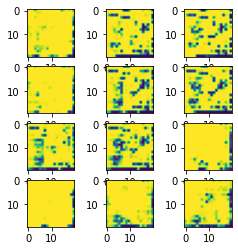

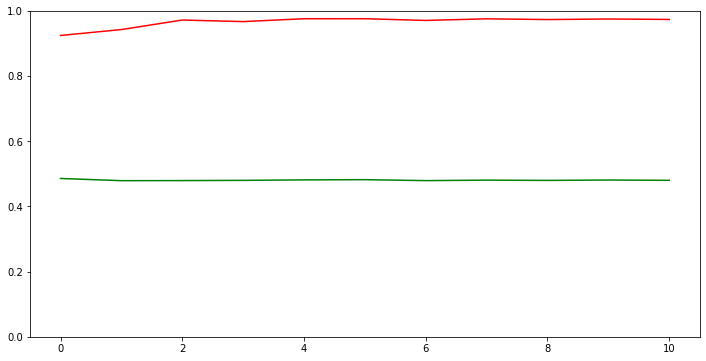

Train Epoch: 12/5000 [0/210229 (0.0%)]


KeyboardInterrupt: ignored

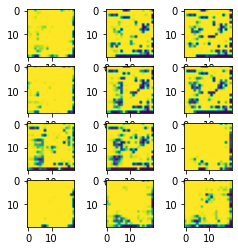

In [127]:
from IPython.display import clear_output

# --------
# TRAINING
# --------

n_epochs = 5000
dataloader = numbers_loader

#images that we're going to use to see the performance of the Generator
# at different epochs
data_show = 12
check_noise, check_cat, check_noise_cat = generate_generator_data(data_show, noise_dim=noise_dim, cat_dim=cat_dim, noise_cat_dim=noise_cat_dim, same_class=False)
check_noise, check_cat, check_noise_cat = check_noise.to(device), check_cat.to(device), check_noise_cat.to(device)

# We set up these variables that are designed for plotting
gen_loss_acum = []
discr_loss_acum = []
features_loss_acum = []

# This training is only performed on the numbers dataset

for epoch in range(n_epochs):

  gen_loss_epoch = 0
  discr_loss_epoch = 0
  features_loss_epoch = 0

  for batch_idx, (real_img_batch, real_img_label) in enumerate(dataloader):

    #print(real_img_label.shape, real_img_label)
    real_img_batch = real_img_batch.to(device)
    real_img_label = torch_dummies(real_img_label, cat_dim).to(device)
    
    #real_img_real_img_batch.type(torch.cuda.FloatTensor)

    ## ------------------
    ## GENERATOR TRAINING
    ## ------------------
    
    gen_optim.zero_grad()
    #if GAN_STYLE == 0: #InfoGAN
    noise, cat, noise_cat = generate_generator_data(BATCH_SIZE, noise_dim, cat_dim, noise_cat_dim)
    noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
    #elif GAN_STYLE == 1: #AC-GAN
    img_batch = generator(noise, cat, noise_cat)
    img_batch = img_batch.to(device)
    ####img_batch = noisy_image(img_batch, epsilon_decay(epoch, EPSILON))
    veracity, cat_pred, _ = discriminator(img_batch)
    veracity, cat_pred = veracity.to(device), cat_pred.to(device)
    if GAN_STYLE == 0: #InfoGAN
      generator_loss = gen_loss(veracity)
    elif GAN_STYLE == 1: #AC-GAN
      generator_loss = gen_loss(veracity, cat, cat_pred)
    generator_loss.backward()
    gen_optim.step()


    ## ----------------------
    ## DISCRIMINATOR TRAINING
    ## ----------------------
    if batch_idx % GEN_PER_DISCR == 0:
      discr_optim.zero_grad()

      # First, we send a batch that has been created from the generator
      noise, cat, noise_cat = generate_generator_data(BATCH_SIZE, noise_dim, cat_dim, noise_cat_dim)
      noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
      img_batch = generator(noise, cat, noise_cat).detach()
      img_batch = img_batch.to(device)
      ####img_batch = noisy_image(img_batch, epsilon_decay(epoch, EPSILON))
      veracity_gen, cat_gen, _ = discriminator(img_batch)

      # Then, we send a batch from the real images
      real_img_batch = real_img_batch.type(torch.cuda.FloatTensor)
      ####real_img_batch = noisy_image(real_img_batch, epsilon_decay(epoch, EPSILON))
      veracity_real, cat_real_pred, _ = discriminator(real_img_batch)

      # We calculate the loss and apply backpropagation
      #print(noise_cat.shape, cat_gen.shape)
      discriminator_loss = discr_loss(veracity_real, veracity_gen, real_img_label, cat_real_pred, cat, cat_gen)
      discriminator_loss.backward()
      discr_optim.step()


    ## ----------------
    ## FEATURE TRAINING
    ## ----------------

    if GAN_STYLE == 0: #InfoGAN
      features_optim.zero_grad()

      noise, cat, noise_cat = generate_generator_data(BATCH_SIZE, noise_dim, cat_dim, noise_cat_dim)
      noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
      img_batch = generator(noise, cat, noise_cat)
      img_batch = img_batch.to(device)
      _, cat_pred, noise_cat_pred = discriminator(img_batch)
      loss = features_loss(cat, cat_pred, noise_cat, noise_cat_pred)
      loss.backward()
      features_optim.step()

    #print(generator_loss, generator_loss.item(), gen_loss_epoch + generator_loss.item())

    gen_loss_epoch = gen_loss_epoch + generator_loss.item()
    discr_loss_epoch = discr_loss_epoch + discriminator_loss.item()
    if GAN_STYLE == 0: #InfoGAN
      features_loss_epoch = features_loss_epoch + loss.item()


    #END OF BATCH TEXT
    if batch_idx % 300 == 0:
      print(
          f'Train Epoch: {epoch+1}/{n_epochs} [{batch_idx*len(real_img_batch)}/{len(dataloader.dataset)} ({round(100. * batch_idx / len(dataloader), 1)}%)]')
      #print(generator_loss, discriminator_loss, gen_loss_epoch, discr_loss_epoch)

  # LOSS PLOT
  with torch.no_grad():
    gen_loss_epoch = gen_loss_epoch / (batch_idx+1)
    discr_loss_epoch = discr_loss_epoch / (batch_idx+1)
    if GAN_STYLE == 0: #InfoGAN
      features_loss_epoch = features_loss_epoch / (batch_idx+1)
    #gen_loss_acum.append(gen_loss_epoch.detach())
    #discr_loss_acum.append(discr_loss_epoch.detach())
    gen_loss_acum.append(gen_loss_epoch)
    discr_loss_acum.append(discr_loss_epoch)
    if GAN_STYLE == 0: #InfoGAN
      #features_loss_acum.append(features_loss_epoch.detach())
      features_loss_acum.append(features_loss_epoch)

  clear_output(wait=True)
  print('GENERATOR loss: ',gen_loss_epoch, '\nDISCRIMINATOR loss: ', discr_loss_epoch)
  if GAN_STYLE == 0: #InfoGAN
    plt.figure(figsize=(12,12))
    ax = plt.subplot(2, 1, 1)
    plt.plot(gen_loss_acum, 'r')
    plt.plot(discr_loss_acum, 'g')
    plt.subplot(2, 1, 2)
    plt.plot(features_loss_acum, 'b')
    plt.show()
  elif GAN_STYLE == 1: #AC_GAN
    plt.figure(figsize=(12,6))
    axes = plt.gca()
    axes.set_ylim([0,1])
    plt.plot(gen_loss_acum, 'r')
    plt.plot(discr_loss_acum, 'g')
    plt.show()

  # SHOW THE GENERATOR'S INNER WORKINGS
  #data_show = 6
  #noise, cat, noise_cat = generate_generator_data(data_show, noise_cat_dim=0)
  #noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
  img_batch = generator(check_noise, check_cat, check_noise_cat)
  plt.figure(figsize=(4,4))
  for i in range(data_show):
    plt.subplot(data_show // 3, 3, i+1)
    plt.imshow(img_batch[i,0,:,:].cpu().detach().numpy())
  

  ##GENERAR EL MISMO RUIDO AL PRINCIPIO DEL ENTRENAMIENTO PARA LOS PLOTS DEL GENERADOR
  # ASÍ SE VE LA EVOLUCIÓN DE LAS MIMSAS MUESTRAS DE RUIDO

In [ ]:
noise, cat, noise_cat = generate_generator_data(20)
noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
img_batch = generator(noise, cat, noise_cat)
plt.imshow(img_batch[14,0,:,:].cpu().detach().numpy())